In [604]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm as cm_mlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
%matplotlib inline
plt.viridis()
from matplotlib import animation, rc, colors
from IPython.display import HTML
from brian2.units import *
import matplotlib as mlib
from scipy import stats
from pprint import pprint as pp
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from simulation_statistics.analysis_functions_definitions import *
import traceback
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as metrics

In [605]:
mlib.rcParams.update({'font.size': 24})
mlib.rcParams.update({'errorbar.capsize': 5})
mlib.rcParams.update({'figure.autolayout': True})

In [606]:
# https://gist.github.com/MatthewJA/5a0a6d75748bf5cb5962cb9d5572a6ce
cyclic_viridis = colors.LinearSegmentedColormap.from_list(
    'cyclic_viridis',
    [(0, cm_mlib.viridis.colors[0]),
     (0.25, cm_mlib.viridis.colors[256 // 3]),
     (0.5, cm_mlib.viridis.colors[2 * 256 // 3]),
     (0.75, cm_mlib.viridis.colors[-1]),
     (1.0, cm_mlib.viridis.colors[0])])

In [607]:
# Random delay initial network
# 2 class (easy?)
# fname = "random_delay_smax_128_gmax_1_384k_sigma_7.5_3_angle_0_90_evo"  # uns:100% score, after change [86%,89% @ 80s]. max:0.72 (87 for wta)
fname = "random_delay_smax_128_gmax_1_192k_sigma_7.5_3_angle_0_90_evo"  # 
# 2 class (harder?)
# fname = "random_delay_smax_128_gmax_1_192k_sigma_7.5_3_angle_45_135_evo"
# 4 class (easy?)
# fname = "random_delay_smax_128_gmax_1_384k_sigma_7.5_3_angle_NESW_evo"  # Pretty bad? -- yup, awful, uns and max
# fname = "random_delay_smax_128_gmax_1_192k_sigma_7.5_3_angle_NESW_evo"


# All angles... this could be interesting
# fname = "random_delay_smax_128_gmax_1_192k_sigma_7.5_3_all_angles" # uns 80 + 160s are awful; max 80 awful



# Constant delay initial network
# fname = "constant_delay_smax_128_gmax_1_192k_sigma_7.5_3_angle_0_90" # ~ 62% at 80s, but a lot of no spikes
# fname = "constant_delay_smax_128_gmax_1_384k_sigma_7.5_3_angle_0_90_diff_shared_seeds"  # ~66% at 40s, a lot of no spikes,69% at 80s


# Complete the file name with training or testing
# training_type = "min"
# training_type = "max"
training_type = "uns"

# Extra suffix (given to distinguish the original file from variations of itself"
extra_suffix = ""
# extra_suffix = "_two_label_spikes" 
# extra_suffix = "_two_label_spikes_p_.2" 
# extra_suffix = "_two_label_spikes_p_.2_wta"  # Awesome for max 
# extra_suffix = "_two_label_spikes_p_.1_wta"   # Awful!  Just awful....
# extra_suffix = "_two_label_spikes_p_.1_wta_80s"   # Better than the 40s version...
# extra_suffix = "_two_label_spikes_p_.2_wta_80s"
# extra_suffix = "_one_spike_label_spikes_p_.2"  # Unacceptable + wta
# extra_suffix = "_one_spike_label_spikes_p_.1"  # Unacceptable + wta
# extra_suffix = "_one_spike_label_spikes_p_.1_wta_80s" # Completely OPPOSITE
# extra_suffix = "_one_spike_label_spikes_p_.2_wta_80s" # Not the worst (over 80%)
# extra_suffix = "_p_0.05"
# extra_suffix = "_rerun" # ace
# extra_suffix = "_wta"
# extra_suffix = "_80s" # why does it go bad? -- does structural plasticity stabilise it
# extra_suffix = "_160s" #
extra_suffix = "_p.2"
# extra_suffix = "_p.05"

####
training_fname = "training_readout_for_" + training_type + "_" +  fname + extra_suffix
testing_fname = "testing_readout_for_" + training_type + "_" + fname + extra_suffix

# root_stats = "D:\Work\Neurogenesis-PhD\simulation_statistics\\"
root_stats = "C:\Work\phd\simulation_statistics\\"

# root_syn = "D:\Work\Neurogenesis-PhD\synaptogenesis\\"
root_syn = "C:\Work\phd\synaptogenesis\\"

suffix_test = ""
# suffix_test = "_shared_seed"
# suffix_test = "_1_angle_jitter"
suffix_test = "_2_angles"
# suffix_test = "_4_angles"
# suffix_test = "_all_angles"
# suffix_test = "_45_degrees"
# suffix_test = "_64x64"

suffix_test += "_" + training_type + extra_suffix
training_data = np.load(root_syn + training_fname + ".npz")
testing_data = np.load(root_syn + testing_fname + ".npz")
# testing_data = np.load(root_syn + "spiking_moving_bar_input\spiking_moving_bar_motif_bank_simtime_1200s.npz")


In [608]:
# Retreive data from testing data
testing_target_spikes = testing_data['target_spikes']
testing_inhibitory_spikes = testing_data['inhibitory_spikes']
testing_readout_spikes = testing_data['readout_spikes']
testing_actual_classes = testing_data['actual_classes'].ravel()
testing_target_readout_projection = testing_data['target_readout_projection']

readout_sim_params = testing_data['readout_sim_params'].ravel()[0]
pp(readout_sim_params)
w_max = readout_sim_params['argparser']['w_max']
simtime = testing_data['simtime'] * ms
chunk = testing_data['chunk'] 

# Retreive data from training data
training_actual_classes = training_data['actual_classes']
training_readout_spikes = training_data['readout_spikes']
target_readout_projection = training_data['target_readout_projection']
wta_projection = training_data['wta_projection']



target_readout_projection = target_readout_projection.reshape(target_readout_projection.size/4, 4)
wta_projection = wta_projection.reshape(wta_projection.size/4, 4)
classes = np.sort(np.unique(testing_actual_classes))

training_data.close()
testing_data.close()

{'a_minus': 0.13,
 'a_plus': 0.1,
 'actual_classes': array([[90, 90, 90,  0, 90, 90,  0, 90,  0, 90,  0, 90, 90,  0, 90, 90,
        90, 90, 90, 90, 90, 90,  0, 90,  0, 90,  0,  0, 90, 90, 90,  0,
         0,  0, 90,  0,  0, 90,  0,  0,  0, 90, 90, 90, 90, 90, 90,  0,
         0, 90,  0, 90, 90, 90,  0, 90, 90, 90,  0,  0,  0, 90, 90,  0,
        90, 90, 90,  0,  0, 90,  0,  0,  0,  0, 90,  0, 90,  0,  0,  0,
         0, 90, 90,  0, 90, 90, 90,  0,  0,  0,  0, 90,  0, 90, 90,  0,
        90, 90,  0,  0,  0, 90, 90,  0,  0,  0, 90,  0,  0,  0, 90,  0,
        90,  0, 90,  0,  0, 90,  0, 90, 90,  0,  0, 90, 90, 90,  0, 90,
         0, 90, 90,  0, 90, 90, 90,  0, 90, 90,  0,  0,  0, 90, 90,  0,
        90,  0,  0,  0, 90,  0, 90, 90,  0, 90, 90,  0,  0, 90,  0,  0,
        90, 90, 90, 90, 90, 90,  0, 90,  0,  0, 90,  0, 90, 90, 90, 90,
        90, 90,  0, 90, 90, 90, 90,  0,  0,  0, 90, 90,  0, 90,  0,  0,
         0, 90,  0,  0, 90,  0,  0,  0]], dtype=int64),
 'argparser': {'a_plus': 0.

In [609]:
assert np.all(testing_target_readout_projection == target_readout_projection), target_readout_projection

# Readout spikes

In [610]:
def plot_spikes(spikes, title, classes, filename):
    if spikes is not None:
        recast_spikes = []
        for index, value in np.ndenumerate(classes):
            recast_spikes.append(spikes[spikes[:,0]==index[0]][:,1])
        f, ax1 = plt.subplots(1, 1, figsize=(15, 6), dpi=600)
#         ax1.set_xlim((0, simtime/ms))
        ax1.set_xlim((0, 1800))
#         print recast_spikes
        ax1.eventplot(recast_spikes, linelengths=.8)
        ax1.set_xlabel('Time/ms')
        ax1.set_ylabel('Class neuron')
        ax1.set_title(title)
        plt.savefig(filename, bbox_inches='tight')
        ax1.set_yticks(np.arange(classes.size))
        ax1.set_yticklabels(np.sort(classes))
        plt.show()

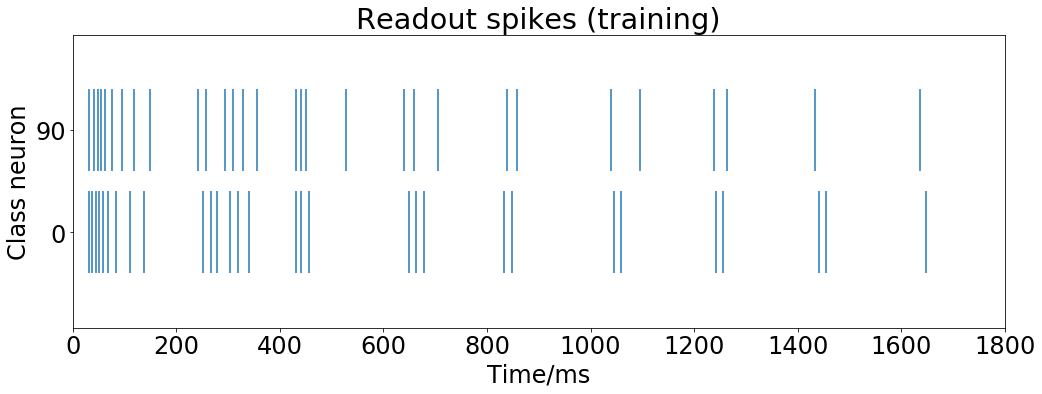

In [611]:
plot_spikes(training_readout_spikes, "Readout spikes (training)", np.unique(testing_actual_classes), "readout_training_spikes{}.pdf".format(suffix_test))

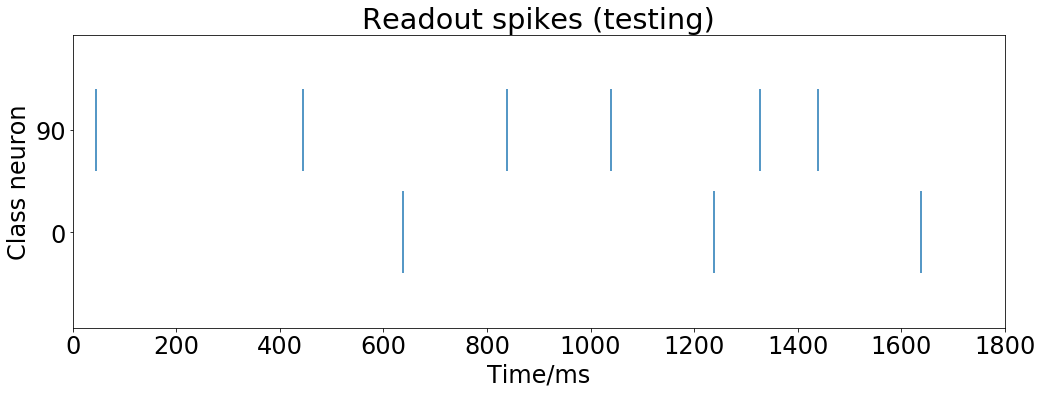

In [612]:
plot_spikes(testing_readout_spikes, "Readout spikes (testing)", np.unique(testing_actual_classes), "readout_testing_spikes{}.pdf".format(suffix_test))

In [613]:
spikes = testing_readout_spikes
print "Testing ----------------"
for index, value in np.ndenumerate(classes):
    print "Number of spikes for class", value, ":", spikes[spikes[:,0]==index[0]].size, "equivalent of ", spikes[spikes[:,0]==index[0]].size / simtime
spikes = training_readout_spikes
print "Training ----------------"
for index, value in np.ndenumerate(classes):
    print "Number of spikes for class", value, ":", spikes[spikes[:,0]==index[0]].size, "equivalent of ", spikes[spikes[:,0]==index[0]].size / simtime

Testing ----------------
Number of spikes for class 0 : 190 equivalent of  4.75 Hz
Number of spikes for class 90 : 218 equivalent of  5.45 Hz
Training ----------------
Number of spikes for class 0 : 384 equivalent of  9.6 Hz
Number of spikes for class 90 : 308 equivalent of  7.7 Hz


# Do readout spikes have any classification power?

In [614]:
import itertools
def class_assignment(spikes, classes=classes,actual_classes=testing_actual_classes, training_type=training_type, simtime=simtime, chunk=chunk):
    # Compute rates and ranks
    print training_type
    # Winner-takes-all
    instaneous_rates = np.empty((classes.size, int((simtime/ms)//chunk)))
    for index, value in np.ndenumerate(instaneous_rates):
        number_index, chunk_index = index
        instaneous_rates[number_index, chunk_index] = np.count_nonzero(
                np.logical_and(
                    spikes[spikes[:,0]==number_index][:, 1] >= (chunk_index * chunk), 
                    spikes[spikes[:,0]==number_index][:, 1] < ((chunk_index+1) * chunk)
                )
            ) 
    what_network_thinks = np.empty(int((simtime/ms)//chunk))
    for i in range(what_network_thinks.shape[0]):
#         what_network_thinks[i] = np.argmax(instaneous_rates[:, i])
        # random tie-breaking
        ir_max = np.max(instaneous_rates[:, i])
        what_network_thinks[i] = np.random.choice(np.flatnonzero(instaneous_rates[:, i]==ir_max))
    # Rank-order
#     first_to_spike = np.ones(int((simtime/ms)//chunk))*0  # Change this to follow all entries that do not spike
    first_to_spike = np.random.randint(0, 2, size=int((simtime/ms)//chunk))
    for index, value in np.ndenumerate(first_to_spike):
        chunk_index = index[0]
        try:
            first_to_spike[chunk_index] = np.sort(spikes[
                    np.where(np.logical_and(
                        spikes[:, 1] >= (chunk_index * chunk), 
                        spikes[:, 1] < ((chunk_index+1) * chunk)
                    ))])[0, 0]
        except:
            print "No spikes", chunk_index
            pass
    
    if training_type == "uns":
        all_class_permutations = list(itertools.permutations(classes))
        wta_likely_classes = []
        wta_max_acc = 0
        rank_order_likely_classes = []
        rank_order_max_acc = 0
        rmse_classes = []
    #     min_rmse = -1.
        min_rmse = 10000
    #     print "all class permutations", all_class_permutations
        for perm in all_class_permutations:
            perm = np.asarray(perm)
            acc_score = metrics.accuracy_score(actual_classes.ravel(), perm[what_network_thinks.astype(int)].ravel())

            if acc_score > wta_max_acc:
                print "wta_",acc_score
                wta_max_acc = acc_score
                wta_likely_classes = perm

            acc_score = metrics.accuracy_score(actual_classes.ravel(), perm[first_to_spike.astype(int)].ravel())
            if acc_score > rank_order_max_acc:
                print "ro_",acc_score
                rank_order_max_acc = acc_score
                rank_order_likely_classes = perm

            rmse = np.sqrt(np.mean(((actual_classes.ravel() - perm[first_to_spike.astype(int)].astype(float).ravel())**2)))
            if rmse < min_rmse:
                print "rmse_",acc_score
                min_rmse = acc_score
                rmse_classes = perm
        wta_predictions = what_network_thinks.astype(int).ravel()
        rank_order_predictions = first_to_spike.astype(int).ravel()
        return wta_predictions, rank_order_predictions, wta_likely_classes, rank_order_likely_classes, rmse_classes
    else:
        wta_predictions = what_network_thinks.astype(int).ravel()
        rank_order_predictions = first_to_spike.astype(int).ravel()
        return wta_predictions, rank_order_predictions, classes, classes, classes

In [615]:
wta_predictions, rank_order_predictions, wta_likely_classes, rank_order_likely_classes, rmse_classes = class_assignment(
    testing_readout_spikes, 
    classes=classes, 
    actual_classes=testing_actual_classes, 
    simtime=simtime, 
    chunk=chunk)

uns
No spikes 1
No spikes 11
No spikes 41
No spikes 69
No spikes 94
No spikes 101
No spikes 106
No spikes 117
No spikes 125
No spikes 127
No spikes 129
No spikes 162
No spikes 172
wta_ 0.945
ro_ 0.95
rmse_ 0.95


In [616]:
print " WTA ---------------"
print classification_report(testing_actual_classes, wta_likely_classes[wta_predictions])
print " WTA LIKELY CLASSES :" , wta_likely_classes
print
print " Rank order --------"
print
print classification_report(testing_actual_classes, 
                            rank_order_likely_classes[rank_order_predictions])
print " RANK ORDER LIKELY CLASSES :" , rank_order_likely_classes

print " RMSE Rank order --------"
print
print classification_report(testing_actual_classes, 
                            rmse_classes[rank_order_predictions])
print " RMSE LIKELY CLASSES :" , rmse_classes

 WTA ---------------
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        93
          90       0.96      0.93      0.95       107

   micro avg       0.94      0.94      0.94       200
   macro avg       0.94      0.95      0.94       200
weighted avg       0.95      0.94      0.95       200

 WTA LIKELY CLASSES : [ 0 90]

 Rank order --------

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        93
          90       1.00      0.91      0.95       107

   micro avg       0.95      0.95      0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200

 RANK ORDER LIKELY CLASSES : [ 0 90]
 RMSE Rank order --------

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        93
          90       1.00      0.91      0.95       107

   micro avg       0.95      0.95      0.95 

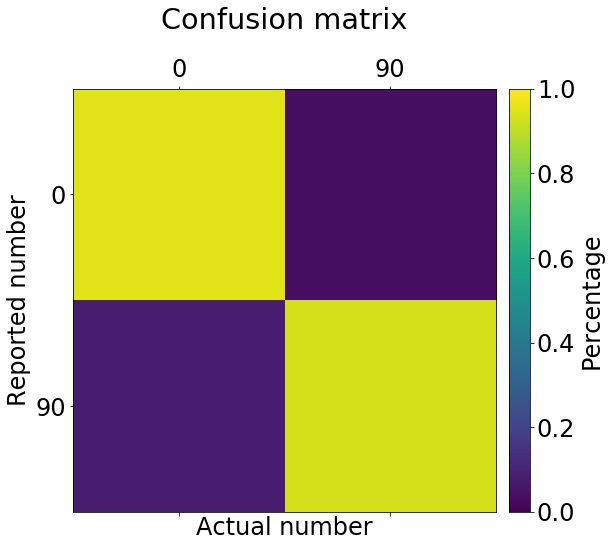

In [617]:
### WTA
confusion = confusion_matrix(testing_actual_classes, wta_likely_classes[wta_predictions],  labels=classes)
confusion = confusion.astype('float') / confusion.sum(axis=1)

fig_conn, ax1 = plt.subplots(1, 1,figsize=(9,9))
    

ff_conn_ax = ax1.matshow(confusion, vmin=0, vmax=1)

ax1.set_title("Confusion matrix\n")
ax1.set_xlabel("Actual number")
ax1.set_ylabel("Reported number")

ax1.set_xticks(np.arange(classes.size))
ax1.set_xticklabels(classes)
ax1.set_yticks(np.arange(classes.size))
ax1.set_yticklabels(classes)


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(ff_conn_ax, cax=cax)
cbar.set_label("Percentage")

plt.tight_layout()
plt.savefig("wta_confusion_matrix{}.pdf".format(suffix_test), bbox_inches='tight', dpi=800)

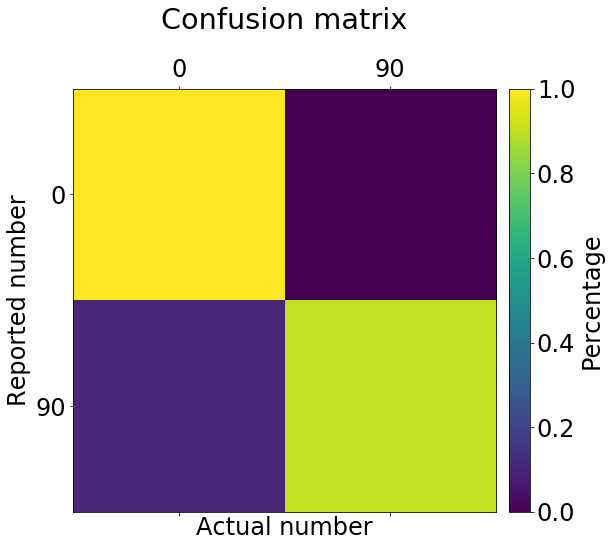

In [618]:
### RANK ORDER
confusion = confusion_matrix(testing_actual_classes, rank_order_likely_classes[rank_order_predictions],  labels=classes)
confusion = confusion.astype('float') / confusion.sum(axis=1)

fig_conn, ax1 = plt.subplots(1, 1,figsize=(9,9))
    

ff_conn_ax = ax1.matshow(confusion, vmin=0, vmax=1)

ax1.set_title("Confusion matrix\n")
ax1.set_xlabel("Actual number")
ax1.set_ylabel("Reported number")

ax1.set_xticks(np.arange(classes.size))
ax1.set_xticklabels(classes)
ax1.set_yticks(np.arange(classes.size))
ax1.set_yticklabels(classes)


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(ff_conn_ax, cax=cax)
cbar.set_label("Percentage")

plt.tight_layout()
plt.savefig("rank_confusion_matrix{}.pdf".format(suffix_test), bbox_inches='tight', dpi=800)

In [619]:
rmse = np.sqrt(np.mean(((testing_actual_classes - wta_likely_classes[wta_predictions])**2)))
print "WTA RMSE", rmse


print "Rank order RMSE"
rmse = np.sqrt(np.mean(((testing_actual_classes -  rank_order_likely_classes[rank_order_predictions])**2)))
print "RMSE", rmse

WTA RMSE 21.106870919205434
Rank order RMSE
RMSE 20.12461179749811


# Readout weights

0.19921875
0.19921875


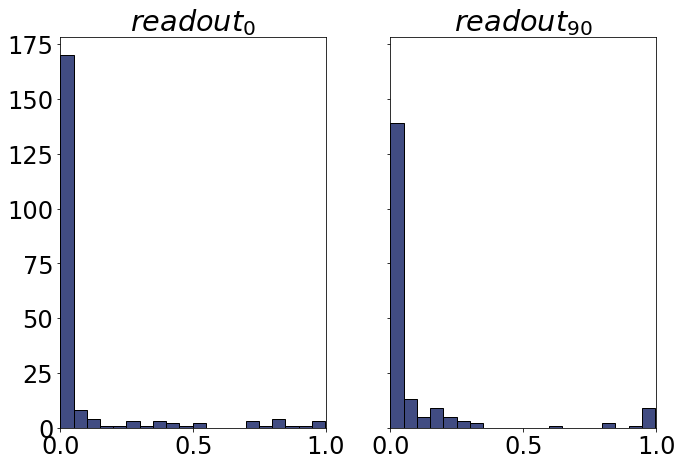

In [620]:
conns = []
conns_names = []
for index, value in np.ndenumerate(classes):
    conns.append(target_readout_projection[target_readout_projection[:,1]==index[0]])
    conns_names.append("$readout_{%s}$" % str(value))
f, axes = plt.subplots(1,classes.size, figsize=(classes.size*5, 7), dpi=800, sharey=True)



minimus = 0
maximus = 1
for index, ax in np.ndenumerate(axes): 
    i = index[0]
    ax.hist(conns[i][:,2]/w_max, bins=20, color='#414C82', edgecolor='k')
    ax.set_title(conns_names[i])
    ax.set_xlim([minimus, maximus])
    print np.max(conns[i][:,2])
    assert np.max(conns[i][:,2]) <= w_max
#     ax.set_xticklabels(["0", "0.5", "1"])
#     print conns[i][:,2]

# f.suptitle("Mean firing rate for specific input angle", va='bottom')
plt.tight_layout()
plt.savefig("readout_weight_histograms{}.pdf".format(suffix_test), bbox_inches='tight')
plt.show()